In [25]:
import nibabel as nib
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import tool
import transforms

def print_his(data):
#     counts = list()
#     for ii in range(10):
#         i = ii / 10
#         counts.append(((data >= i) & (data < i+0.1)).sum().item())

    plt.figure()
    plt.hist(data)
#     plt.bar(range(10),counts)
#     plt.xlim(0, 1)
    plt.show()
#     print(counts)
    
def save_nib(data_nib, ftemplate, postfix):
    output_file = ftemplate.replace('@@@@', postfix)
    nib.save(data_nib, output_file)
    print('Writing output file: ', output_file)
    return output_file

In [29]:
img_org, img_affine = tool.nib_to_tensor(
    nib.load(r'CC0009_philips_15_69_M.nii.gz'), resample='continuous')

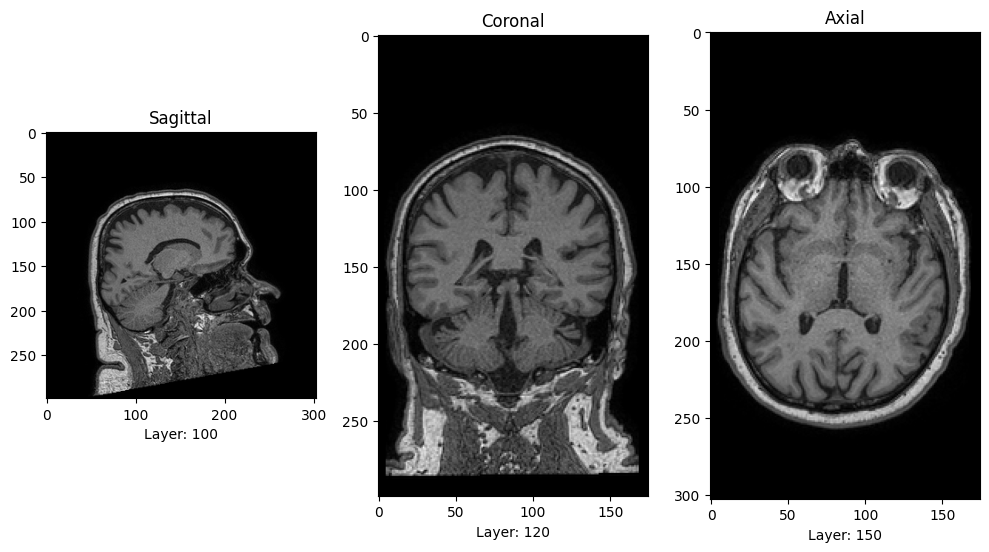

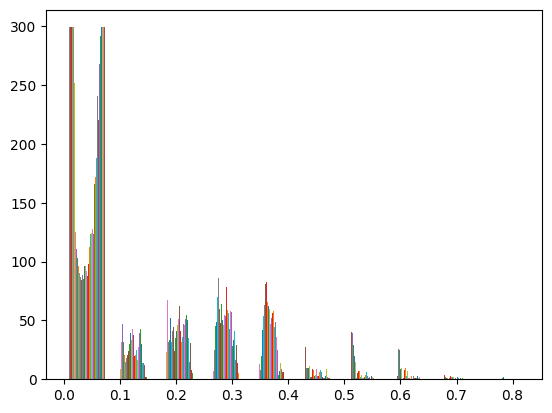

In [30]:
img = transforms.Rescale()(img_org)
tool.show_slices(img[0, 0, ...], (100, 120, 150), 'gray')
print_his(img[0, 0, 100, :, :])

In [50]:
def get_gauss(sigma, kernel_size = 3):
    # Calculate the center of the kernel
    center = (kernel_size - 1) / 2

    # Create a 3D coordinate grid
    x = torch.linspace(-center, center, kernel_size)
    y = torch.linspace(-center, center, kernel_size)
    z = torch.linspace(-center, center, kernel_size)
    xx, yy, zz = torch.meshgrid(x, y, z, indexing="ij")

    # Calculate the Gaussian function
    gaussian = torch.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2))

    # Normalize the kernel so that it sums to 1
    gaussian = gaussian / torch.sum(gaussian)
    
    return gaussian

def RedistributeContrast1(image):
    gauss_kernel = get_gauss(sigma=1)
    image = F.conv3d(image, weight=gauss_kernel[None, None, ...], padding=1) # Guassian Blur
    tool.show_slices(image[0, 0, ...], (100, 120, 150), 'gray')
    
    new_image = image + 0
    d = np.random.permutation(10) / 10
    for ii, v in enumerate(d):
        i = ii / 10
        print(i, v)
        new_image[(image >= i) & (image < i+0.1)] += (v - i)

    return new_image

def RedistributeContrast2(image):
    gauss_kernel = get_gauss(sigma=1)
    image = F.conv3d(image, weight=gauss_kernel[None, None, ...], padding=1) # Guassian Blur
    tool.show_slices(image[0, 0, ...], (100, 120, 150), 'gray')
    
    new_image = image * 1
    d = np.random.uniform(low=0, high=0.9, size=10)
#     d = np.ones((10,)) * 0.9
#     d[0] = 0
    for ii, v in enumerate(d):
        i = ii / 10
        print(i, v)
        new_image[(image >= i) & (image < i+0.1)] += (v - i)

    return new_image

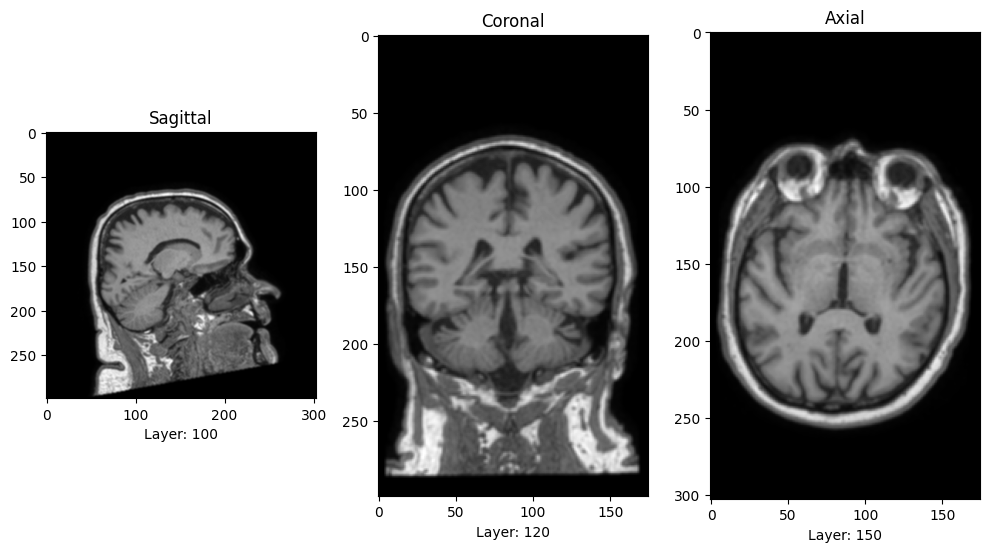

0.0 0.5
0.1 0.2
0.2 0.8
0.3 0.0
0.4 0.4
0.5 0.9
0.6 0.6
0.7 0.7
0.8 0.3
0.9 0.1


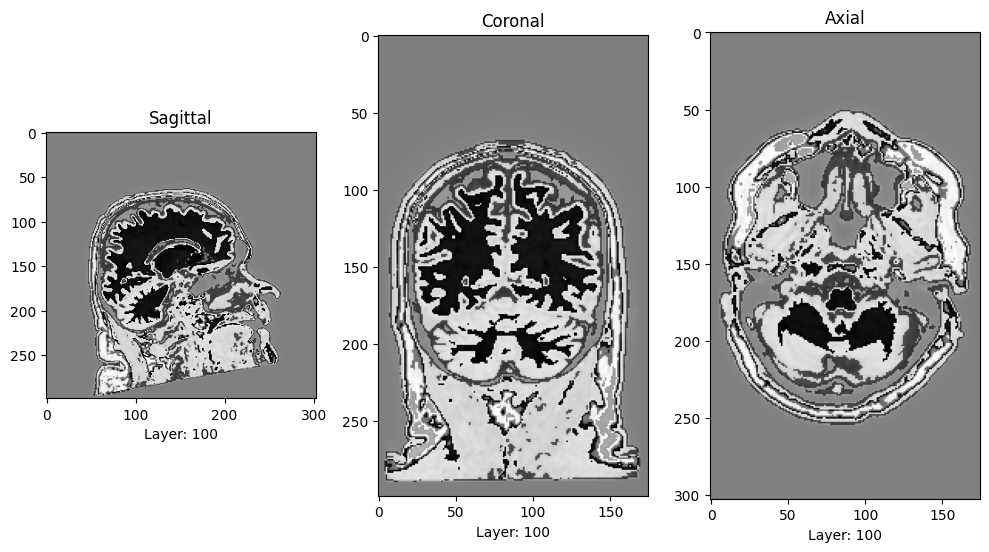

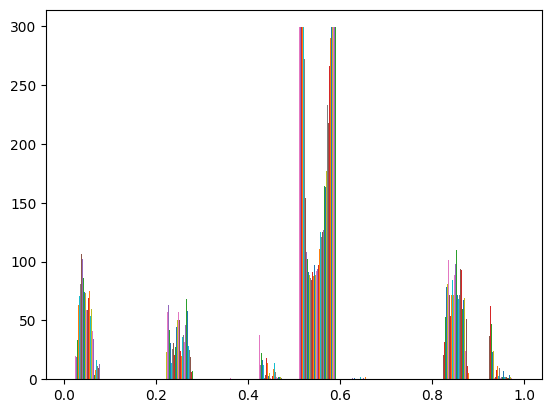

tensor(8.9407e-08) tensor(1.0000)


In [41]:
new_img = RedistributeContrast1(img)
tool.show_slices(new_img[0, 0, ...], (100, 100, 100), 'gray')
print_his(new_img[0, 0, 100, :, :])
print(new_img.min(), new_img.max())

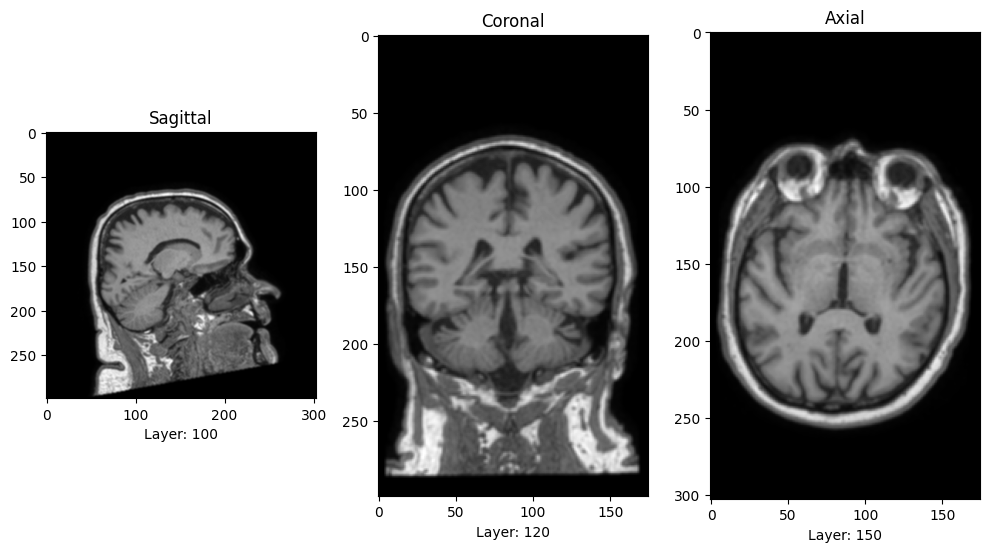

0.0 0.09941194642285238
0.1 0.5624644488785767
0.2 0.5893242341708974
0.3 0.3819119973743651
0.4 0.6070315436805144
0.5 0.21872637225180636
0.6 0.37872242553019714
0.7 0.4467008960806067
0.8 0.05730936390769083
0.9 0.1500204095213756


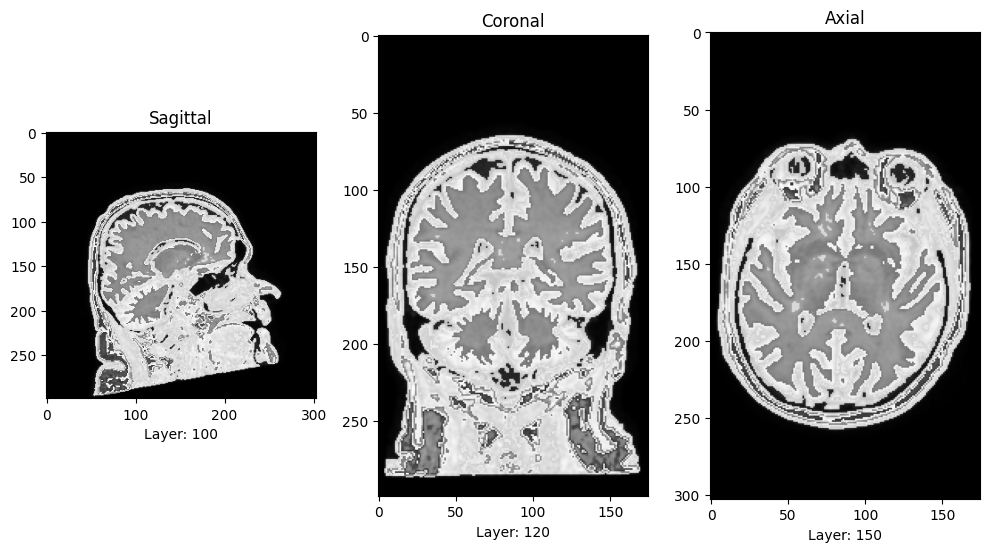

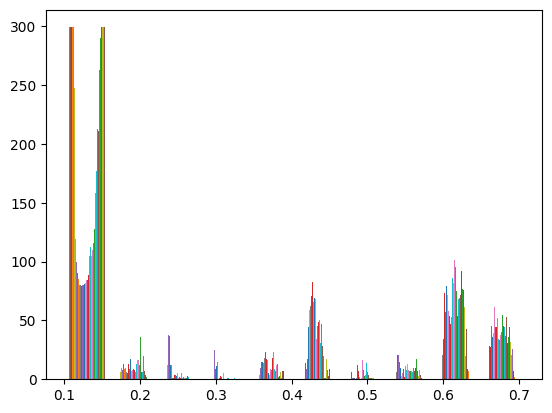

In [51]:
new_img = RedistributeContrast2(img)
tool.show_slices(new_img[0, 0, ...], (100, 120, 150), 'gray')
print_his(new_img[0, 0, 100, :, :])

In [29]:
output_nib = nib.Nifti1Image(new_img[0, 0, ...].numpy(), img_affine)
save_nib(output_nib, 'image_@@@@.nii.gz', 'newImage')

Writing output file:  image_newImage.nii.gz


'image_newImage.nii.gz'

In [19]:
class GammaTransform():
    def __init__(self, std=0.4):
        self.std = std

    def __call__(self, image):
        r = np.random.normal(0, self.std)
        return torch.pow( image, np.exp(r) )

In [114]:
np.random.normal(0, 0.4)

-0.5129302102281549

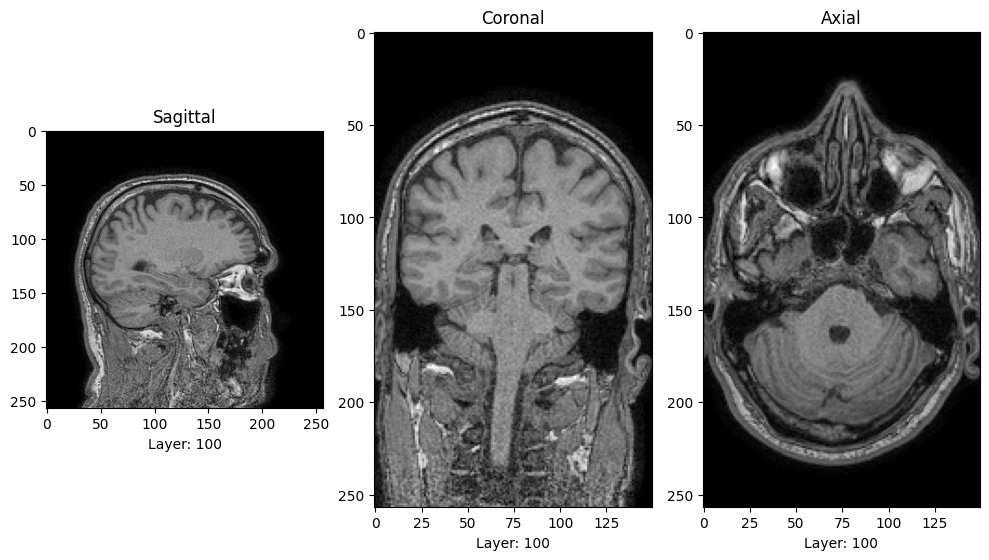

In [115]:
i = GammaTransform()(img)
tool.show_slices(i[0, 0, ...], (100, 100, 100), 'gray')